In this example we
- download a source file
- access netCDF grids
- perform a mesh decimation to reduce point numbers

In [1]:
# Download the data from source
import urllib.request
import tarfile
import os.path

fileout = 'data.tar.gz'

if not os.path.isfile(fileout):
  url='http://onlinelibrary.wiley.com/store/10.1002/2017JB014296/asset/supinfo/2017JB014296-sup-0002-Data_Set_SI-S01_AA.gz?v=1&s=867faff69e418861f269b9e4b4feaf9268154f65'
  print("Downloading source file")
  urllib.request.urlretrieve(url, 'data.tar.gz')
else:
  print("File exists.")

print("Extracting to local folder")
f = tarfile.open(name='data.tar.gz', mode='r').extractall()

File exists.
Extracting to local folder


In [2]:
# Access netCDF and create a vtkPoints oject with the data
import netCDF4
import vtk

vexag = 20

colors = vtk.vtkNamedColors()
interface = netCDF4.Dataset("grids/Crust.nc")
nx = interface.variables['x'].shape[0]
ny = interface.variables['y'].shape[0]
points = vtk.vtkPoints()
print("Creating vtkPoints")
for px in range(nx):
    for py in range(ny):
        zval = interface.variables['z'][py, px]*vexag
        if zval > 0:
          zval = 0
        points.InsertNextPoint(interface.variables['x'][px],
                               interface.variables['y'][py],
                               zval)

pointPD = vtk.vtkPolyData()
pointPD.SetPoints(points)

Creating vtkPoints


In [3]:
# Perform delaunay triangulation
delny = vtk.vtkDelaunay2D()
delny.SetInputData(pointPD)
delny.Update()

In [4]:
# Optional plot of the triangulation
if False:
  aCellArray = vtk.vtkCellArray()
  boundary = vtk.vtkPolyData()
  boundary.SetPoints(pointPD.GetPoints())
  boundary.SetPolys(aCellArray)

  meshMapper = vtk.vtkPolyDataMapper()
  meshMapper.SetInputConnection(delny.GetOutputPort())

  meshActor = vtk.vtkActor()
  meshActor.SetMapper(meshMapper)
  meshActor.GetProperty().SetEdgeColor(0, 0, 1)
  meshActor.GetProperty().SetInterpolationToFlat()
  meshActor.GetProperty().SetRepresentationToWireframe()

  boundaryMapper = vtk.vtkPolyDataMapper()
  if vtk.VTK_MAJOR_VERSION <= 5:
      boundaryMapper.SetInputConnection(boundary.GetProducerPort())
  else:
      boundaryMapper.SetInputData(boundary)

  boundaryActor = vtk.vtkActor()
  boundaryActor.SetMapper(boundaryMapper)
  boundaryActor.GetProperty().SetColor(1, 0, 0)

  renderer = vtk.vtkRenderer()
  renderWindow = vtk.vtkRenderWindow()
  renderWindow.AddRenderer(renderer)
  renderWindowInteractor = vtk.vtkRenderWindowInteractor()
  renderWindowInteractor.SetRenderWindow(renderWindow)
  renderer.AddActor(meshActor)
  renderer.AddActor(boundaryActor)
  renderer.SetBackground(.3, .6, .3)

  renderWindowInteractor.Initialize()
  renderWindow.Render()
  renderWindowInteractor.Start()

In [5]:
# Decimate triangulation
print("Decimate")
AbsoluteError=1. # Don't know if that works?!
print("Absolute error:", AbsoluteError)
deci = vtk.vtkDecimatePro()
deci.SetInputConnection(delny.GetOutputPort())
deci.SetErrorIsAbsolute(1) # Read from SetAbsoluteError
#deci.SetAbsoluteError(AbsoluteError) # What is the difference to max error?
deci.SetMaximumError(AbsoluteError)
deci.SetTargetReduction(0.9)
deci.PreserveTopologyOn()
deci.SetFeatureAngle(19)
deci.Update()

Decimate
Absolute error: 1.0


In [6]:
# Save decimated points to file
import numpy as np
decimatedPoly = vtk.vtkPolyData()
decimatedPoly.ShallowCopy(deci.GetOutput())
for i in range(decimatedPoly.GetNumberOfPoints()):
    if i is 0:
        final_points = np.array(decimatedPoly.GetPoint(i))
    else:
        final_points = np.vstack((final_points, decimatedPoly.GetPoint(i)))
final_points[:,2]/=vexag
np.savetxt('DecimatedCrust.csv', final_points, fmt='%f', delimiter=',')

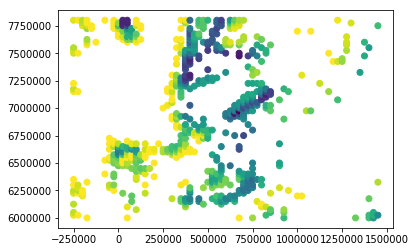

In [7]:
# Create point plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(final_points[:,0], final_points[:,1], c=final_points[:,2])
plt.show()

In [8]:

final_points.shape

(607, 3)

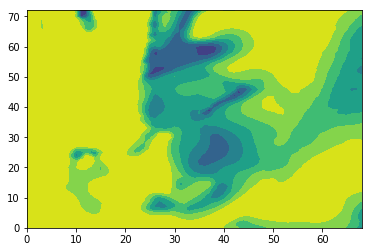

In [9]:
# Compute dip and dip direction from the original data
import math
bouguerInterface = np.array((interface.variables['z'][:,:]), dtype='float64')
bouguerInterface[bouguerInterface>0] = 0
plt.contourf(bouguerInterface)

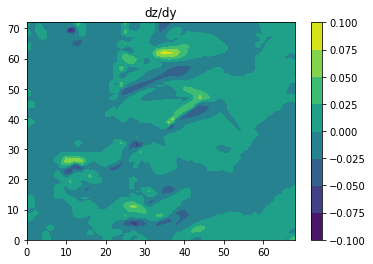

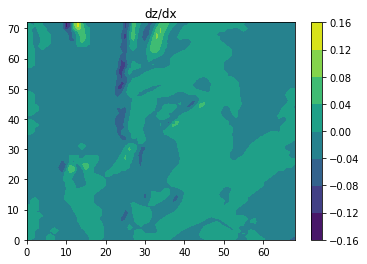

In [10]:
interfaceGradients = np.gradient(bouguerInterface, 25000)
# Compute the absolute gradients
interfaceGradient = np.sqrt(
                    np.multiply(interfaceGradients[0], interfaceGradients[0]) +
                    np.multiply(interfaceGradients[1], interfaceGradients[1])
                    )
plt.figure()
plt.contourf(interfaceGradients[0])
plt.title('dz/dy')
plt.colorbar()
plt.figure()
plt.contourf(interfaceGradients[1])
plt.title('dz/dx')
plt.colorbar()

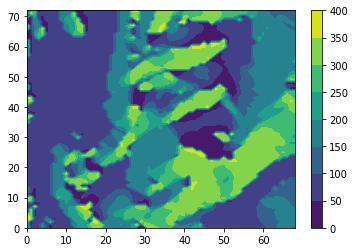

In [11]:
# Compute dip direction
interfaceAzimuth = 90-np.arctan2(interfaceGradients[1], interfaceGradients[0])*180./math.pi
interfaceAzimuth[interfaceAzimuth<0]+=360.
plt.contourf(interfaceAzimuth)
plt.colorbar()

In [12]:
print("Max azimuth:", interfaceAzimuth.max())
print("Min azimuth:", interfaceAzimuth.min())
print("Max gradient:",interfaceGradient.max())
print("Min gradient / deg:", np.arctan(interfaceGradient.min())*180./math.pi)
print("Max gradient / deg:",np.arctan(interfaceGradient.max())*180./math.pi)
#plt.contourf(interfaceGradient)

Max azimuth: 359.838251046
Min azimuth: 0.0
Max gradient: 0.135945047731
Min gradient / deg: 0.0
Max gradient / deg: 7.74161916836


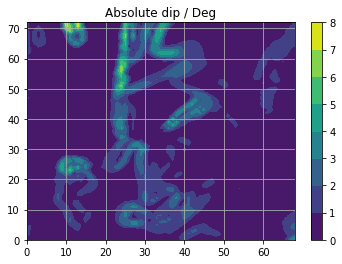

In [13]:
plt.figure()
plt.contourf(interfaceGradient*180./math.pi)
plt.title('Absolute dip / Deg')
plt.colorbar()
plt.grid()

In [14]:
# Sample the gradients
nsamples = 100
xmax = interface.variables['x'][-1]
xmin = interface.variables['x'][0]
ymax = interface.variables['y'][-1]
ymin = interface.variables['y'][0]
#xrnd = np.random.randint(0, nx, nsamples)
#yrnd = np.random.randint(0, ny, nsamples)
randRavel = np.random.choice(range(nx*ny), nsamples, replace=False)
yrnd, xrnd = np.unravel_index(randRavel, (ny,nx))

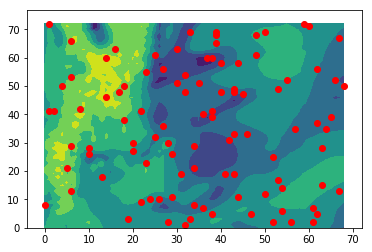

In [15]:
plt.figure()
plt.contourf(interface.variables['z'][:][:])
plt.scatter(xrnd, yrnd, c='r')

In [16]:
interfaceZ = np.array(interface.variables['z'])
interfaceZ[interfaceZ>0] = 0
h='X, Y, Z, Azimuth, Dip'
rndResult = np.zeros([nsamples, 5])
rndResult[:, 0] = interface.variables['x'][xrnd]
rndResult[:, 1] = interface.variables['y'][yrnd]
rndResult[:, 2] = interfaceZ[yrnd, xrnd]
rndResult[:, 3] = interfaceAzimuth[yrnd, xrnd]
rndResult[:, 4] = interfaceGradient[yrnd, xrnd]

In [17]:
np.savetxt('SampledCrust.csv', rndResult, fmt='%f', header=h, delimiter=',')